# Walkthrough - Mutual Info vs. Score for Multivariate Distributions

This notebook will go through some of the results of the experiment. We will be looking at the 4 factors (standardization, sigma estimator, sigma format and HSIC estimator) and try to discern how the relationship between the score and the mutual information content. It will be a bit tedious to go through things step by step, but hopefully at the end we will recover some sort of relationship.



In [1]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import pathlib

import warnings
from typing import Optional, Tuple
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.distribution import DataParams, Inputs

# Kernel Dependency measure
from models.dependence import HSICModel
from pysim.kernel.utils import GammaParam, SigmaParam
from sklearn.gaussian_process.kernels import RBF

# RBIG IT measures
# from models.ite_algorithms import run_rbig_models

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from tqdm import tqdm

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
warnings.filterwarnings('ignore') # get rid of annoying warnings
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

## Data

In [2]:
FIG_PATH = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/mutual_info/"
RES_PATH = "/home/emmanuel/projects/2019_hsic_align/data/results/distributions/mutual_info/"

In [3]:
!ls $RES_PATH

old  v2_gauss.csv  v2_tstudent.csv  v3_gauss.csv  v3_tstudent.csv


## Datasets

* Samples - [500, 1K, 5K, 10K, 30K, 50K]
* Dimensions - [ 2, 3, 10, 50, 100]
* trials - `1:5`
* IT measures - Mutual Information
* Distributions - [Gaussian, T-Student]

## T-student Dataset

In [4]:
header = [
    "dataset",
    "trial",
    "std",
    "nu",
    "samples",
    "dimensions",
    "standardize",
    "per_dimension",
    "separate_scales",
            # SIGMA METHOD PARAMS
    "sigma_method",
    "sigma_percent",
    "sigma_X",
    "sigma_Y",
            # HSIC Params
    "scorer",
    "score",
    "mutual_info",
]

In [5]:
dataset = 'gauss' # other option tstudent

# results_df = pd.read_csv(f"{RES_PATH}old/{dataset}_mi.csv")
results_df = pd.concat([
    pd.read_csv(f"{RES_PATH}/v3_{dataset}.csv", index_col=0),
#     pd.read_csv(f"{RES_PATH}/tstudent_mi.csv", index_col=0)
], )
results_df.tail()

,dataset,trial,std,nu,samples,dimensions,standardize,per_dimension,separate_scales,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
72595,gauss,3,10,1,1000,100,False,False,True,median,0.6,12.155468486773366,12.162266644633538,cka,0.966180,4.499836
72596,gauss,4,9,1,1000,3,True,True,True,median,0.7,"[1.231808543687941, 1.2683032892452757, 1.3248...","[1.2830421106381964, 1.2864799758681433, 1.345...",ka,0.690803,0.227706
72597,gauss,3,5,1,1000,3,True,False,True,median,0.7,2.5454157789422895,2.511007319936148,ka,0.918447,0.063609
72598,gauss,2,9,1,1000,10,True,False,True,median,0.7,4.475119613359233,4.572660190532879,hsic,0.009036,0.642396
72599,gauss,1,3,1,1000,2,False,True,False,median,0.3,0.4820529963785358,0.4820529963785358,hsic,0.000832,0.007718


### Cleaning

So we need to clean this up a little bit. 

* We don't need the sigma values (for now)
* We should take the average of the trials to get some estimates

In [103]:
res_df_ = results_df.copy()

# drop sigma, dataset name columns
res_df_ = res_df_.drop([
#     'sigma_X', 'sigma_Y', 
    'dataset'], axis=1)

# =================
# average trials
# =================

# get dependent variables
dependent_vars = [
    # Daataset params
    "std",
    "nu",
    "samples",
    "dimensions",
    # STANDARDIZE PARAMS
    "standardize",
    # SIGMA FORMAT PARAMS
    "per_dimension",
    "separate_scales",
    # SIGMA METHOD PARAMS
    "sigma_method",
    "sigma_percent",
    # HSIC Params
    "scorer",
    "score",
    "mutual_info",
#     "trial"
]

res_df_ = res_df_[res_df_['trial'] == 1].drop('trial', axis=1)
# res_df_.set_index(dependent_vars).groupby(['trial']).mean()

In [104]:
res_df_.head()

,std,nu,samples,dimensions,standardize,per_dimension,separate_scales,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
3,6,1,50,10,False,False,True,median,0.6,4.587135794016568,4.532509381053911,cka,0.429800,0.345177
4,2,1,50,3,True,False,False,median,0.5,2.121602678238625,2.121602678238625,cka,0.073628,0.006926
6,7,1,50,100,True,True,True,median,0.6,"[1.0758027372612888, 0.917571157405785, 0.9510...","[1.1113174977338918, 1.0792566072679066, 1.146...",ka,1.000000,1.852470
12,6,1,50,10,True,True,False,median,0.9,2.09805241194907,2.09805241194907,hsic,0.015722,0.345177
15,5,1,50,10,False,True,True,median,0.4,"[0.6540492606563242, 0.5471914802282377, 0.654...","[0.7206302062452035, 0.6874572716393927, 0.630...",cka,0.999924,0.270526


## Case I - Different HSIC Scorer

In [97]:
def plot_scores(df: pd.DataFrame) -> None:
    # choose the 3 cases (i.e. the scorers)
    fig, ax = plt.subplots(ncols=3, figsize=(20,5))

    # Case I HSIC
    scorer = 'hsic'
    case_ = df[df['scorer'] == scorer]

    ax[0].scatter(case_.score.values, case_.mutual_info.values, s=10,)
    ax[0].set_title(f'{scorer.upper()}')
    ax[0].set_xlabel(f'Score')
    ax[0].set_ylabel('Mutual Info')


    # Case II - CKA
    scorer = 'cka'
    case_ = df[df['scorer'] == scorer]

    ax[1].scatter(case_.score.values, case_.mutual_info.values, s=10,)
    ax[1].set_title(f'{scorer.upper()}')
    ax[1].set_xlabel(f'Score')
    ax[1].set_ylabel('Mutual Info')
    # ax[1].set_yscale('log')

    # Case III - KA
    scorer = 'ka'
    case_ = df[df['scorer'] == scorer]

    ax[2].scatter(case_.score.values, case_.mutual_info.values, s=10,)
    ax[2].set_title(f'{scorer.upper()}')
    ax[2].set_xlabel(f'Score')
    ax[2].set_ylabel('Mutual Info')


    plt.show()
    return None

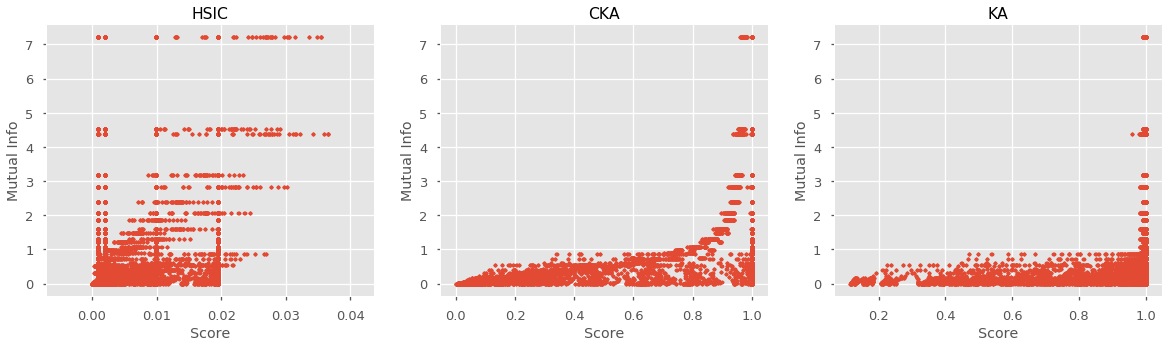

In [98]:
plot_scores(res_df_)

As we can see, this is nearly impossible to discern. The patterns are all over the place. So let's break down this further.

### Case II - Sigma Estimator

We have a few different methods for estimating sigma.

* Scott, Silverman
* Median Values

#### Silverman, Scott

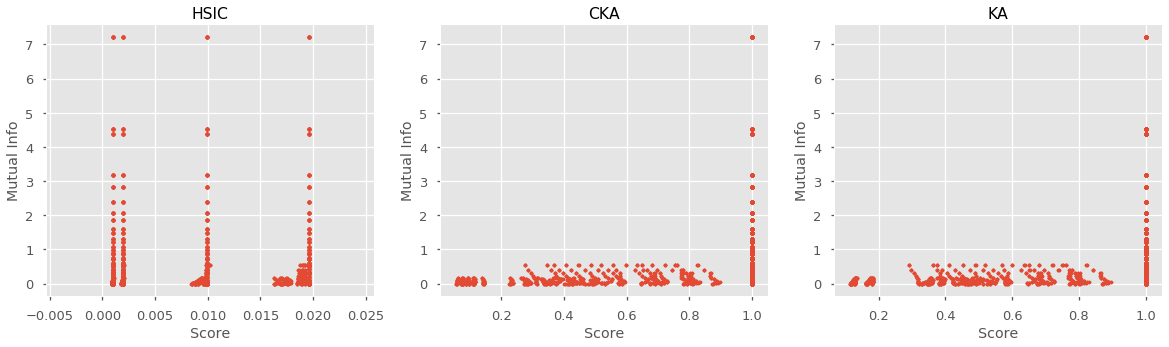

In [78]:
constant_methods = ['scott', 'silverman']

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]

plot_scores(sub_df_)

#### Medians


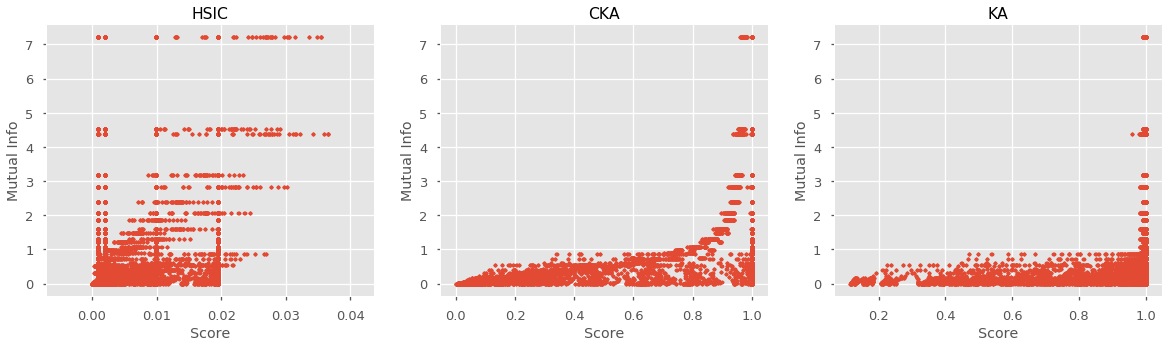

In [79]:
percent_methods = res_df_['sigma_percent'].unique().tolist()

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]

plot_scores(sub_df_)

#### Medians - Reasonable

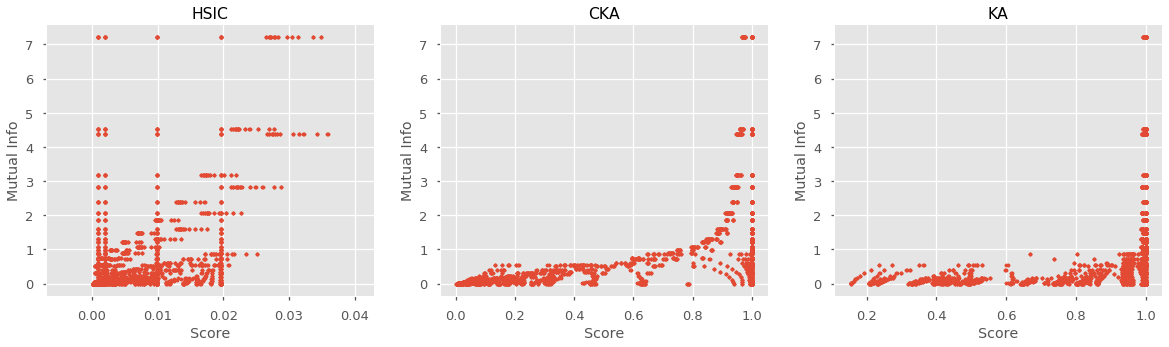

In [80]:
percent_methods = [0.30000000000000004, 0.4, 0.5]
# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]

plot_scores(sub_df_)

## Case III - Sigma Configuration

* Same Length Scale
* Separate Length Scales
* Length Scale per Dimension

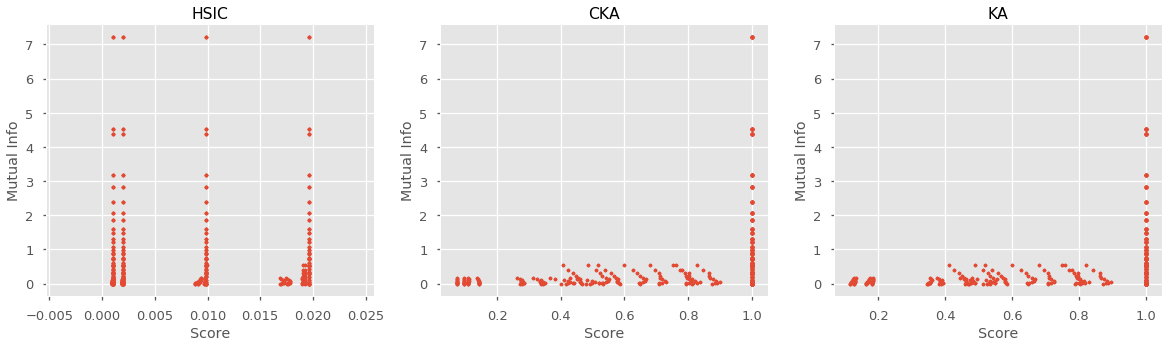

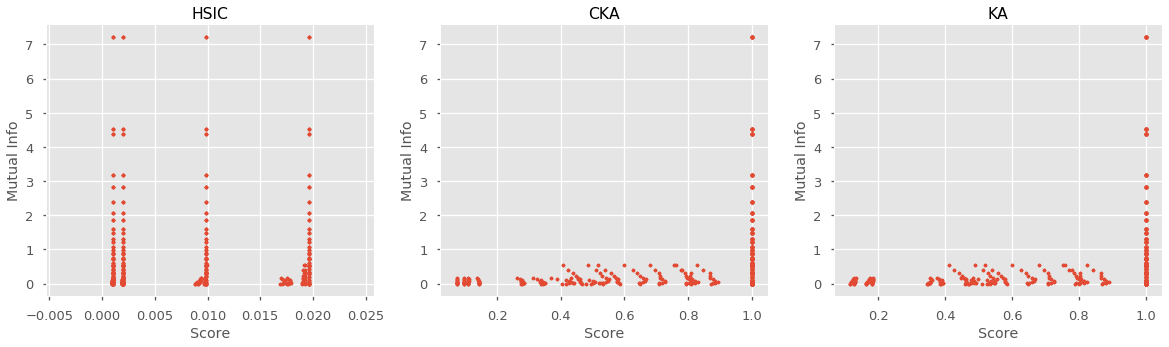

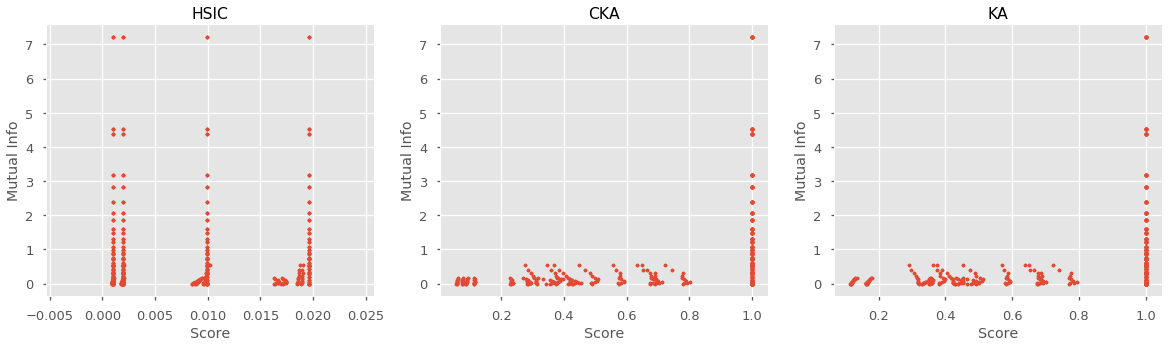

In [84]:
constant_methods = ['scott', 'silverman']
# seperate_length_scale =

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]

plot_scores(sub_df_)

#### Estimator - Medians

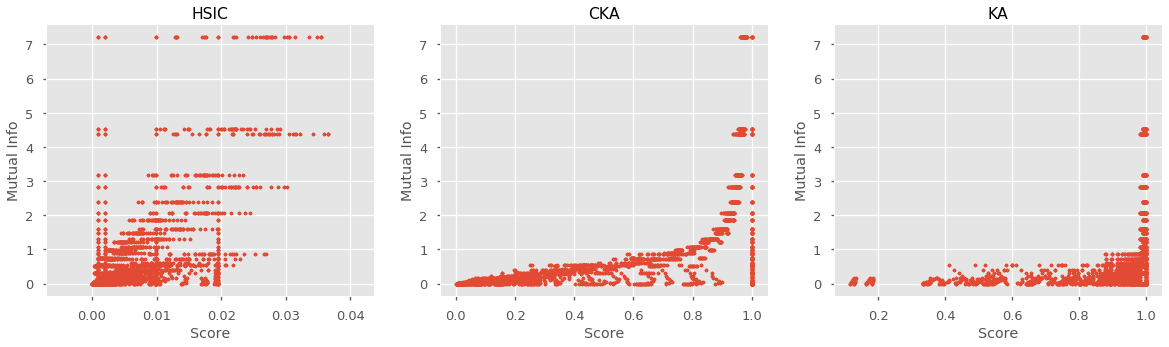

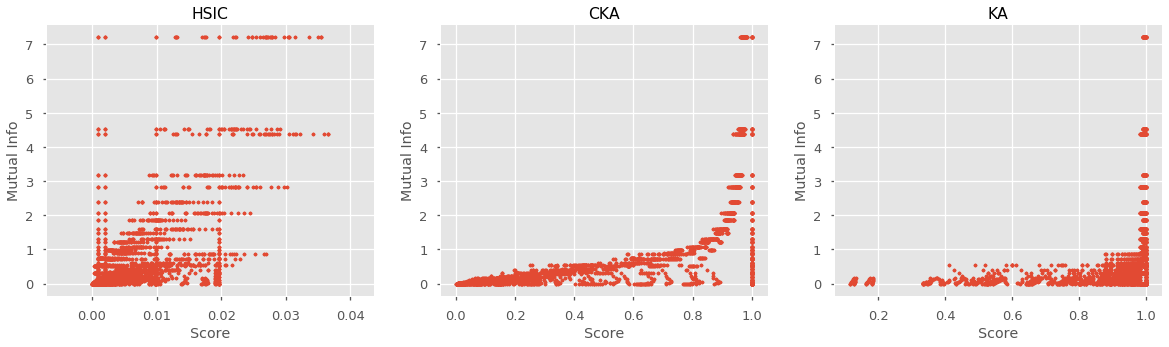

Per Dimension, Same Data


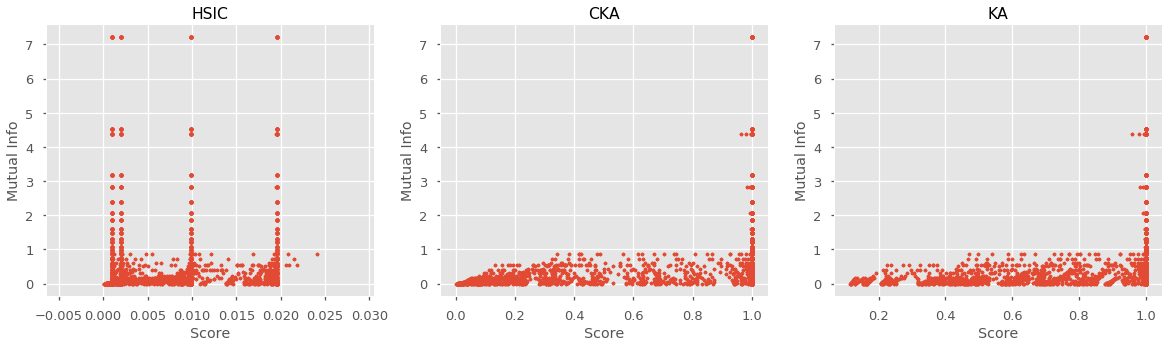

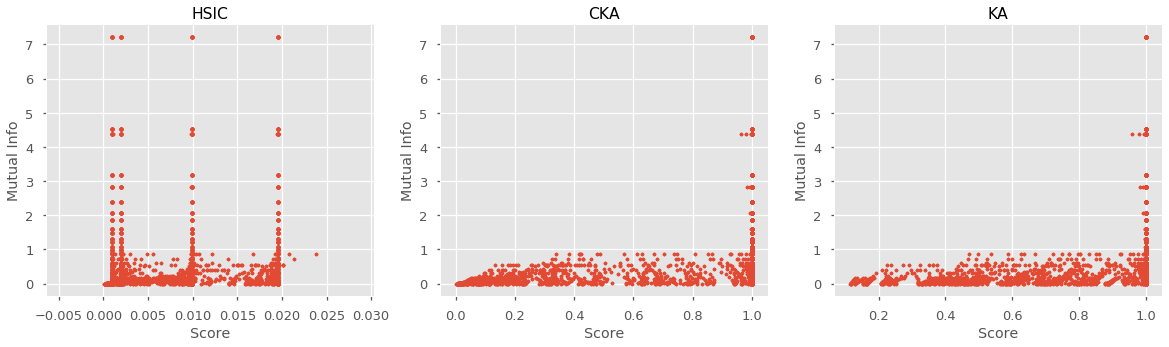

In [99]:
percent_methods = res_df_['sigma_percent'].unique().tolist()
# seperate_length_scale =

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
print("Per Dimension, Same Data")
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]

plot_scores(sub_df_)

#### Sigma Estimator - Medians, Reasonable

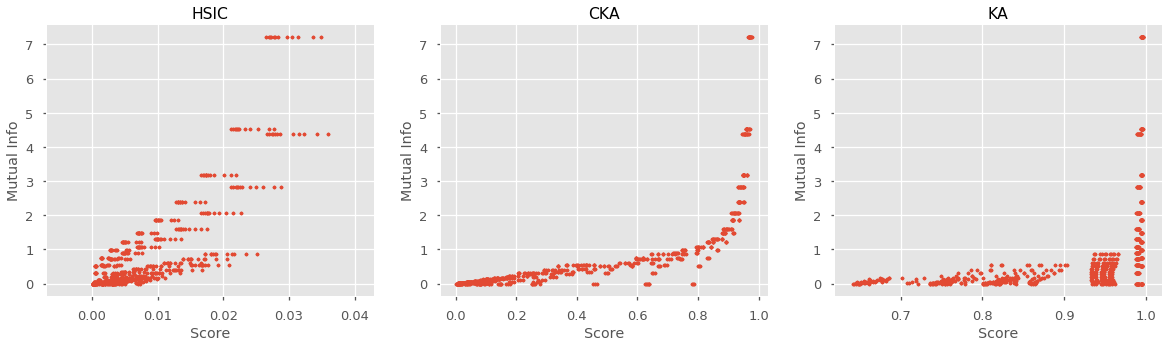

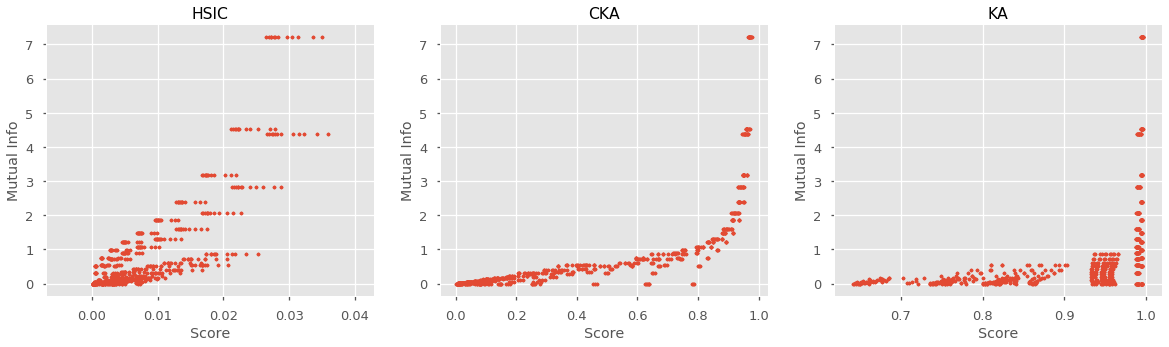

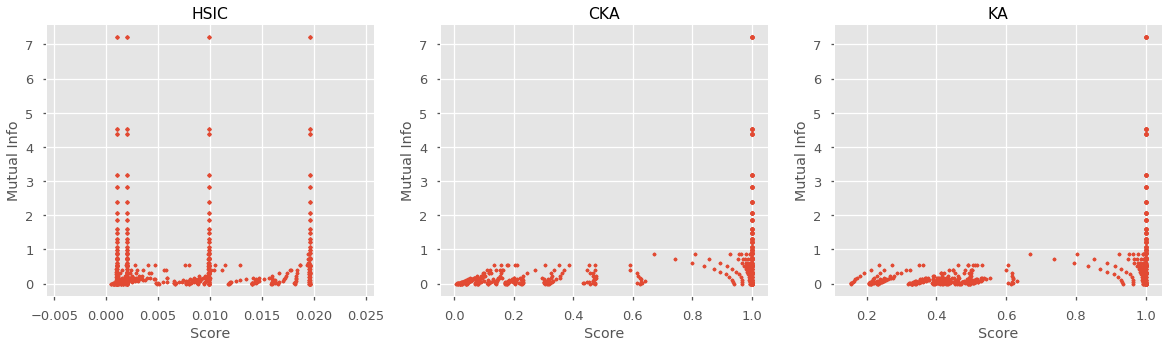

In [86]:
percent_methods = [0.30000000000000004, 0.4, 0.5]

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]

plot_scores(sub_df_)

## Case IV - Standardize or Not

#### Estimator: Scott/Silverman | NOT Standardized

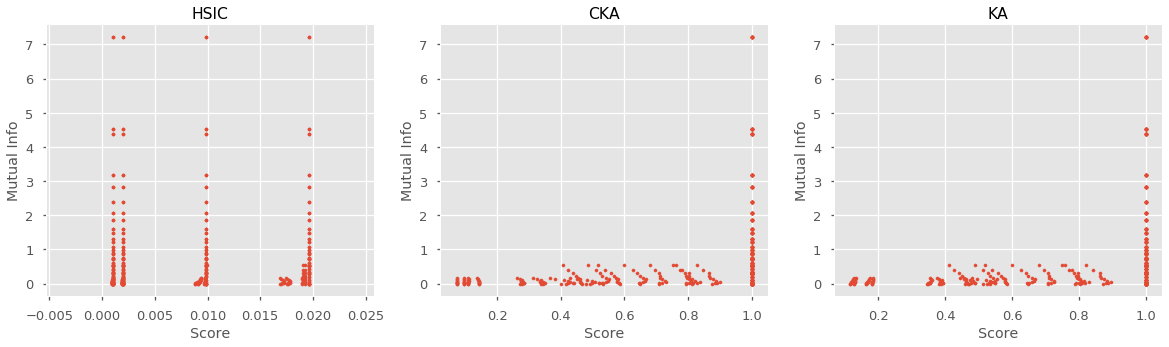

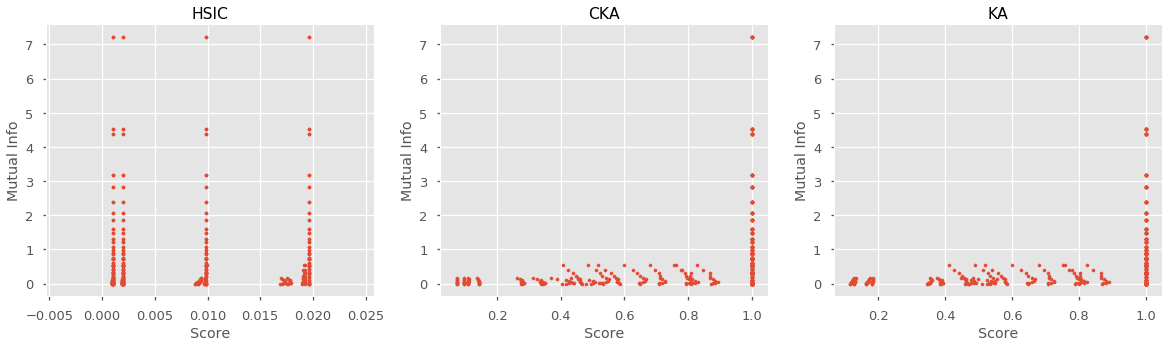

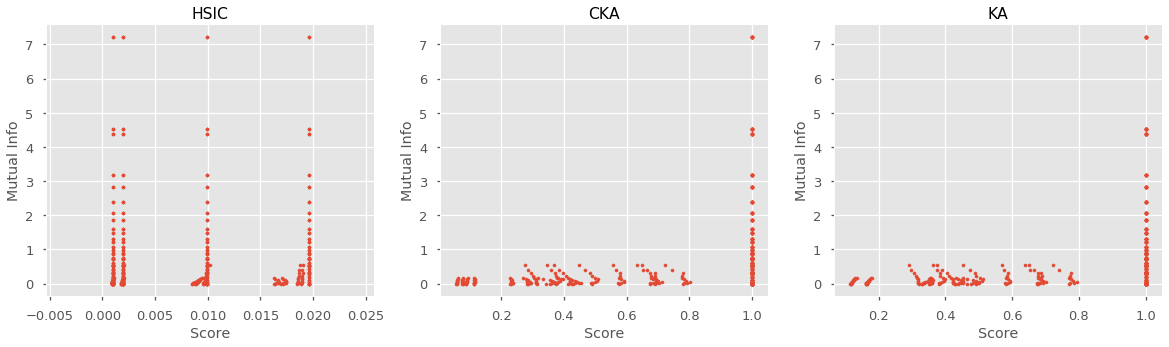

In [87]:
constant_methods = ['scott', 'silverman']
# seperate_length_scale =

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

#### Scott / Silverman | Standardized

Same Scale, Same Dim


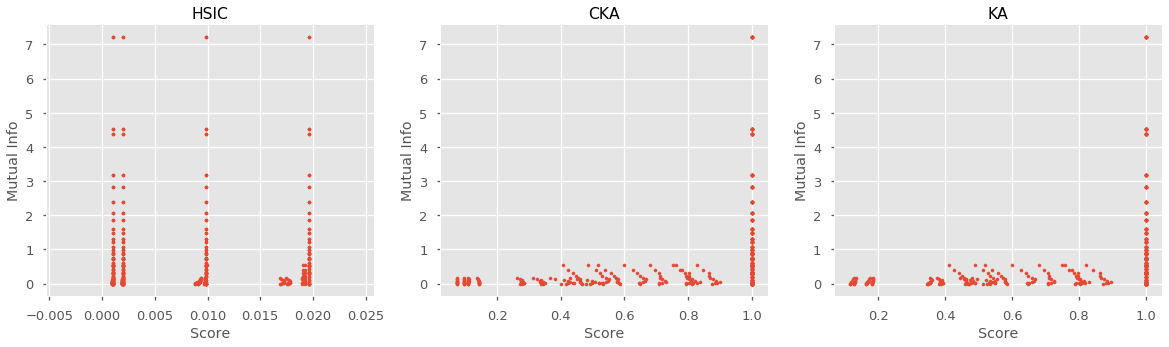

Per Scale, Same Dim


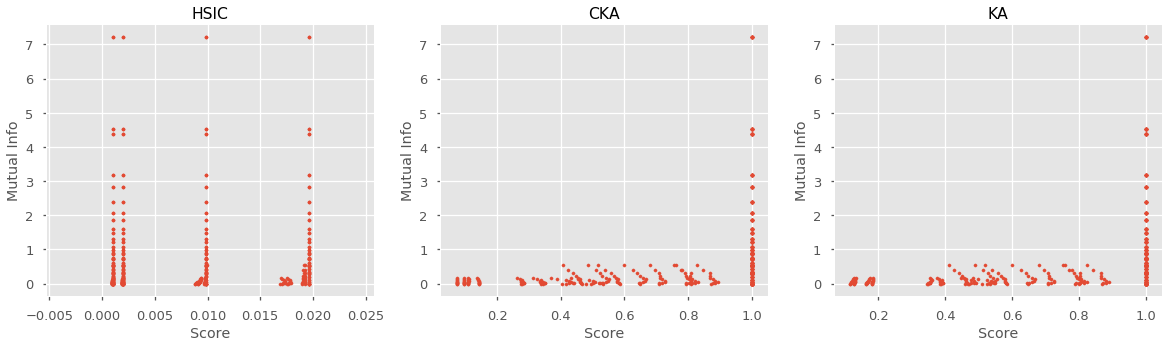

Per Scale, Per Dim


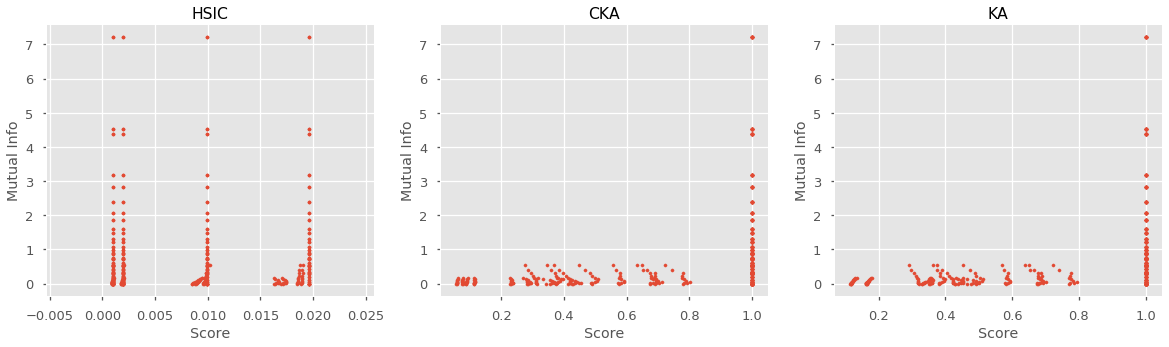

In [90]:
constant_methods = ['scott', 'silverman']
# seperate_length_scale =

# subset dataset
print('Same Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Per Dim')
sub_df_ = res_df_[res_df_['sigma_method'].isin(constant_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

#### Medians | Not Standardized

Same Scale, Same Dim


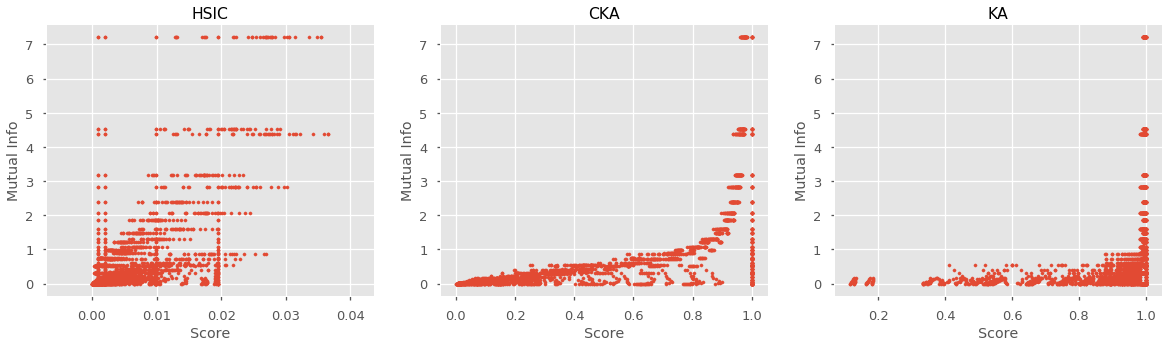

Per Scale, Same Dim


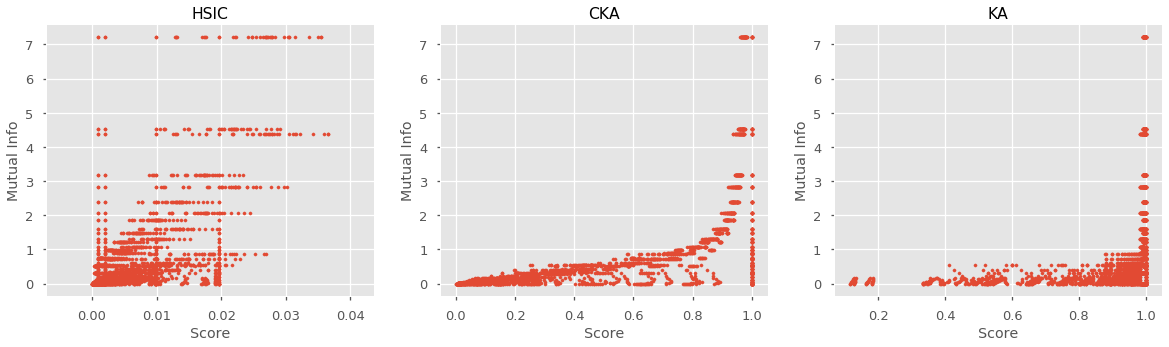

Per Scale, Per Dim


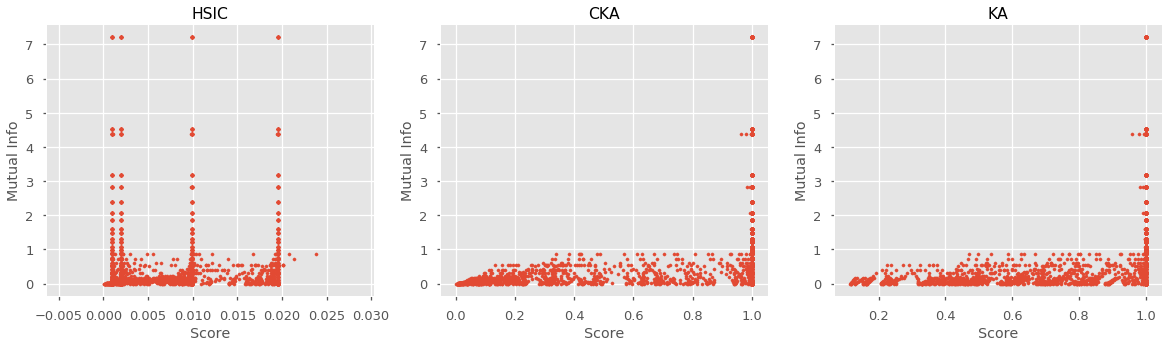

In [91]:
percent_methods = res_df_['sigma_percent'].unique().tolist()
# seperate_length_scale =

# subset dataset
print('Same Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Per Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

#### Medians | STANDARDIZED

Same Scale, Same Dim, Standardized


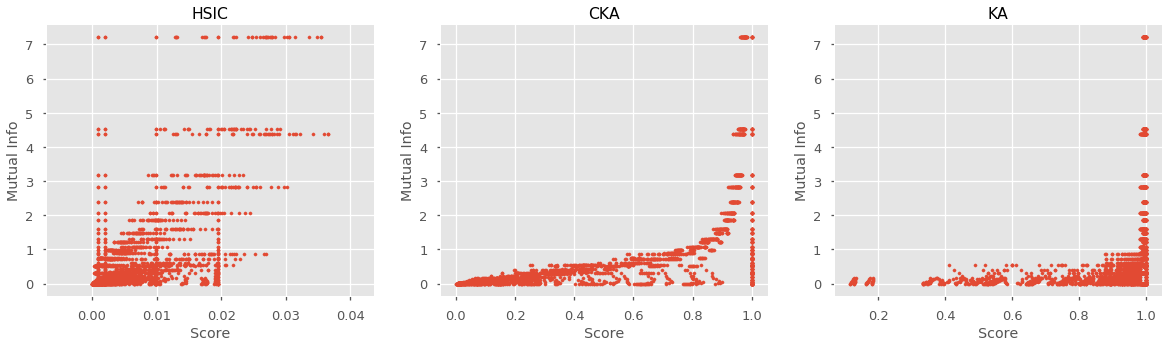

Per Scale, Same Dim, Standardized


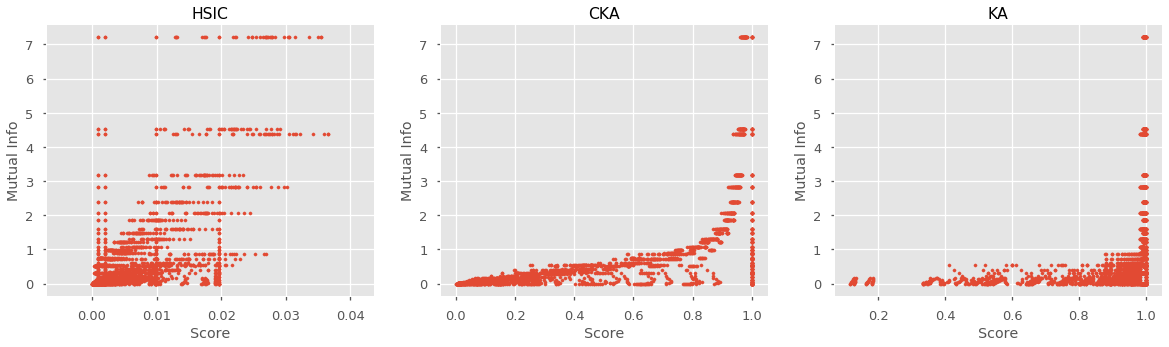

Per Scale, Per Dim, Standardized


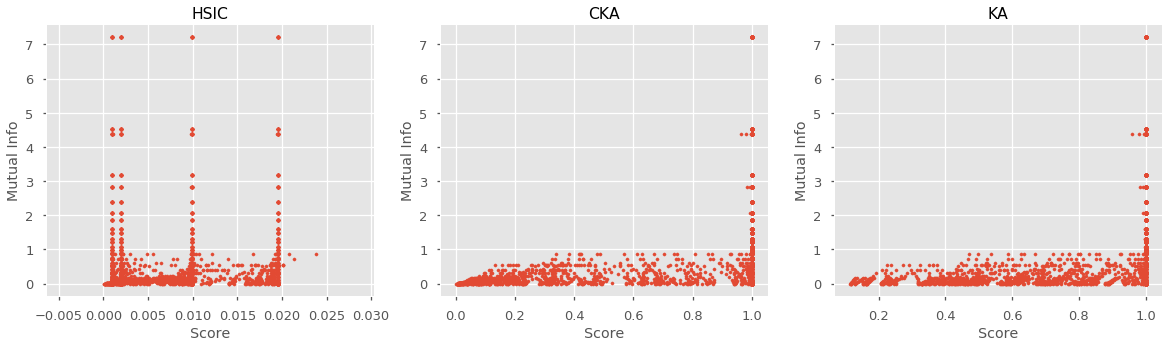

In [92]:
percent_methods = res_df_['sigma_percent'].unique().tolist()
# seperate_length_scale =

# subset dataset
print('Same Scale, Same Dim, Standardized')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Same Dim, Standardized')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Per Dim, Standardized')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
sub_df_ = sub_df_[sub_df_['standardize'] == True]

plot_scores(sub_df_)

#### Medians (Reasonable) | NOT STANDARDIZED

Same Scale, Same Dim


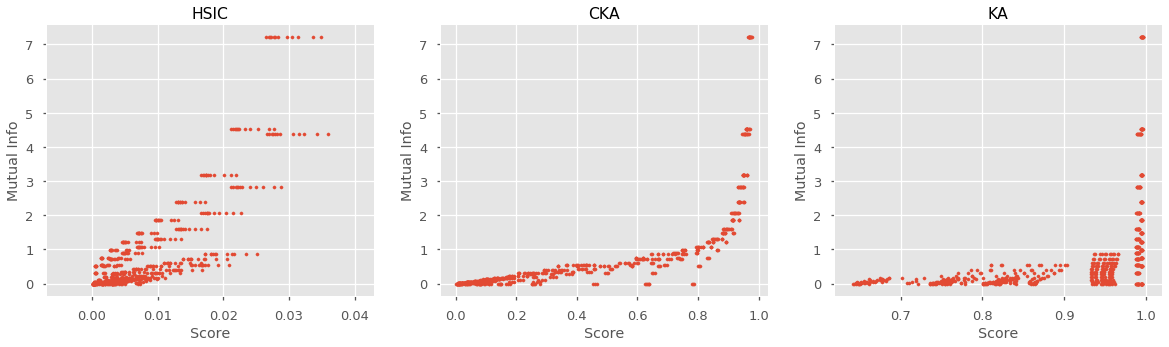

Per Scale, Same Dim


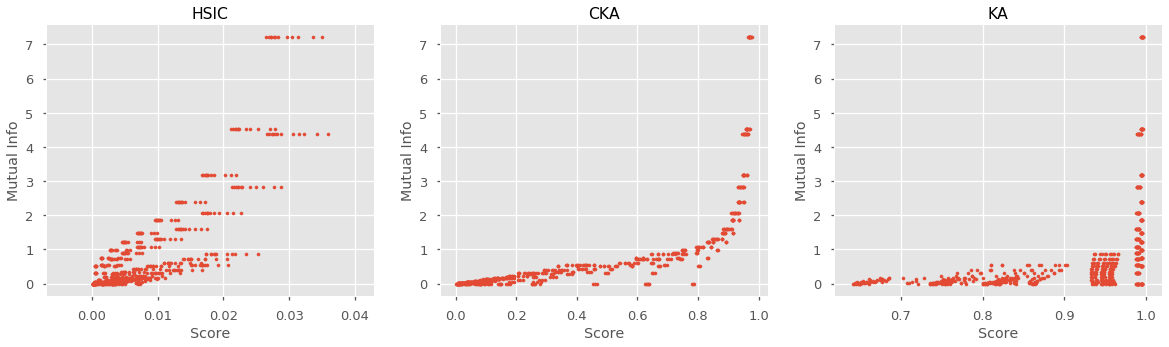

Per Scale, Per Dim


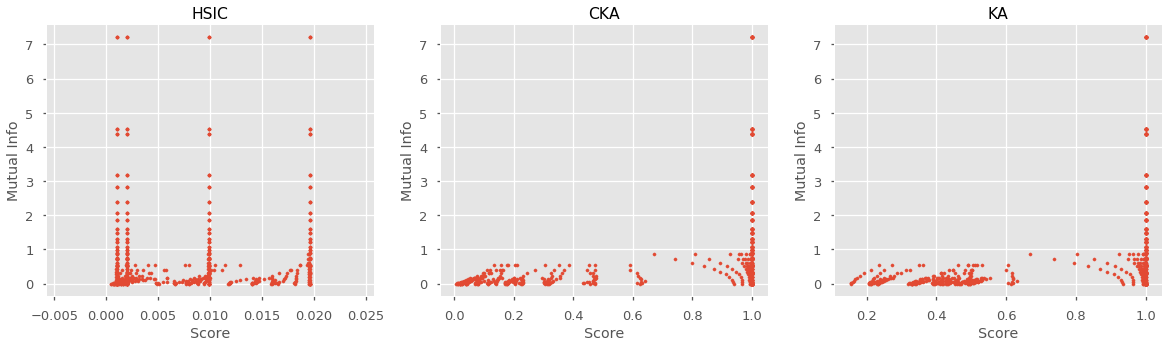

In [93]:
percent_methods = [0.30000000000000004, 0.4, 0.5]
# seperate_length_scale =

# subset dataset
print('Same Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Same Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

# subset dataset
print('Per Scale, Per Dim')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
sub_df_ = sub_df_[sub_df_['standardize'] == False]

plot_scores(sub_df_)

#### Medians (Reasonable) | STANDARDIZED

* Mix - Dimensions, Samples
* Colors
    * Sigma Config - separate length, per dimension, same all, standardize or not
    * Show 1 estimator!

**Objective**: We want 1 method to rule them all!!



Same Scale, Same Dim, STANDARDIZED


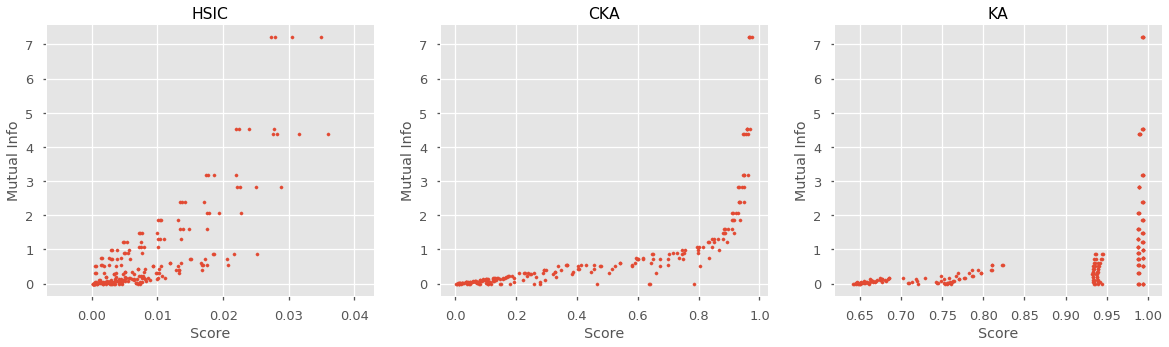

In [108]:
percent_methods = [0.30000000000000004]
# seperate_length_scale =

# subset dataset
print('Same Scale, Same Dim, STANDARDIZED')
sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
sub_df_ = sub_df_[sub_df_['separate_scales'] == False]
sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
sub_df_ = sub_df_[sub_df_['standardize'] == True]
# sub_df_ = sub_df_[sub_df_['dimensions'] == 50]
# sub_df_ = sub_df_[sub_df_['samples'] == 50]

sub_df_.head()

plot_scores(sub_df_)

# # subset dataset
# print('Per Scale, Same Dim, STANDARDIZED')
# sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
# sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
# sub_df_ = sub_df_[sub_df_['per_dimension'] == False]
# sub_df_ = sub_df_[sub_df_['standardize'] == True]

# plot_scores(sub_df_)

# # subset dataset
# print('Per Scale, Per Dim, STANDARDIZED')
# sub_df_ = res_df_[res_df_['sigma_percent'].isin(percent_methods)]
# sub_df_ = sub_df_[sub_df_['separate_scales'] == True]
# sub_df_ = sub_df_[sub_df_['per_dimension'] == True]
# sub_df_ = sub_df_[sub_df_['standardize'] == True]

# plot_scores(sub_df_)

## Viz I - Difference in Method

For the first visualization, we're just going to get a general overview of how each method performs

In [47]:
from typing import List, Callable

def plot_individual_scores(
    scores_df: pd.DataFrame, 
    gamma_estimators: List, 
    scorer: str,
    dataset: str='gauss',
    mi_scale: Optional[Callable[[np.ndarray], np.ndarray]]=None
):
    # intialize plot
    fig, ax = plt.subplots()
    
    # subset dataset
    df_ = scores_df[scores_df['dataset'] == dataset]

    # subset hsic method
    df_ = df_[df_['scorer'] == scorer]
    
    if mi_scale is not None:
        df_['mutual_info'] = mi_scale(df_['mutual_info'])
    
    # subset gamma estimators
    for iestimator in gamma_estimators:
        # subsets
        sub_df = df_[df_['gamma_method'] == iestimator[0]]
        if iestimator[1] is not None:
            sub_df = sub_df[sub_df['gamma_percent'] == iestimator[1]]
        if iestimator[2] is not None:
            sub_df = sub_df[sub_df['gamma_scale'] == iestimator[2]]
        
        name = list(filter(None, iestimator))
        name = '_'.join(str(i) for i in name)
        ax.scatter(
            sub_df.score, 
            sub_df.mutual_info,
            s=50, label=f"{name}", zorder=3, marker='.')
    

    return fig, ax

#### Viz - Scott, Silverman

This should be the worst one for each of them because this method isn't taking into account the dimensions or the samples in a very smart way. It's fine for 1D examples, but we know that this isn't very good for data with a large number of samples or large number of dimensions.

In [48]:
demo_params = [
    ('silverman',None, None),
    ('scott', None, None),
#     *[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]
]

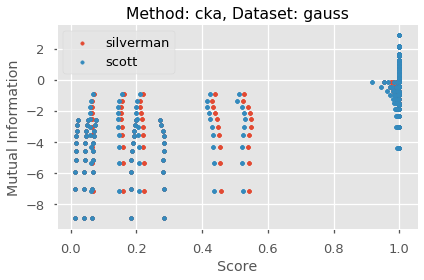

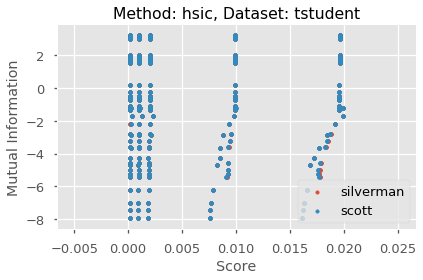

In [49]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

scorer = 'hsic'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")



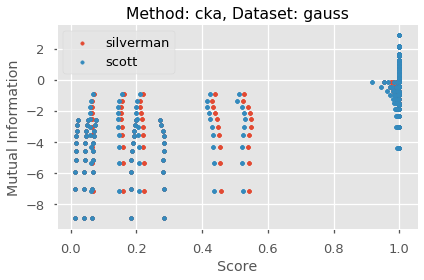

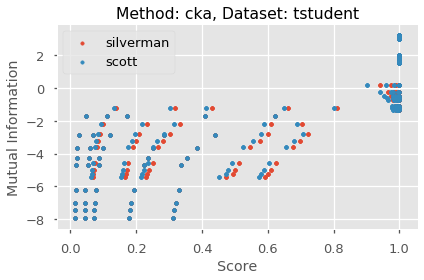

In [51]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

scorer = 'cka'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

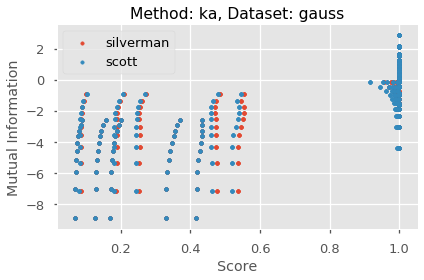

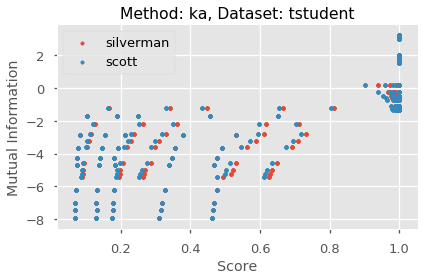

In [52]:
scorer = 'ka'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

scorer = 'ka'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_standard.png")

#### Viz - Median Distances (All)

So for this, I will be looking at a few median distance values. This is the standard method so it will be good to compare.

In [91]:
[('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]

[('median', 0.1, None),
 ('median', 0.2, None),
 ('median', 0.30000000000000004, None),
 ('median', 0.4, None),
 ('median', 0.5, None),
 ('median', 0.6, None),
 ('median', 0.7000000000000001, None),
 ('median', 0.8, None),
 ('median', 0.9, None)]

In [53]:
demo_params = [
    ('median', 0.30000000000000004, None),
    ('median', 0.5, None),
    ('median', 0.7000000000000001, None),
]
demo_params = [('median', x, None) for x in np.arange(0.1, 1.0, 0.1, dtype=np.float64)]

In [ ]:
projects/2019_hsic_align/results/figures/distribution_experiment/mutual_info

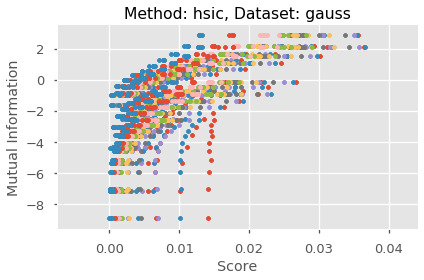

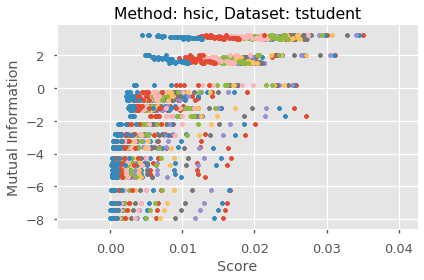

In [55]:
scorer = 'hsic'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'hsic'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")


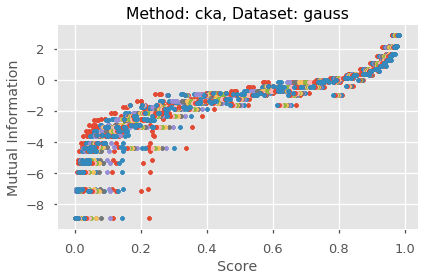

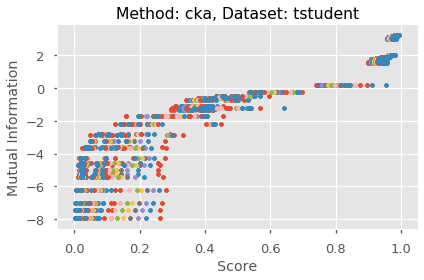

In [56]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'cka'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

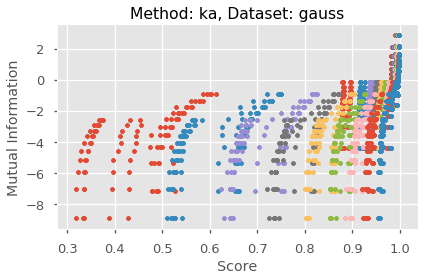

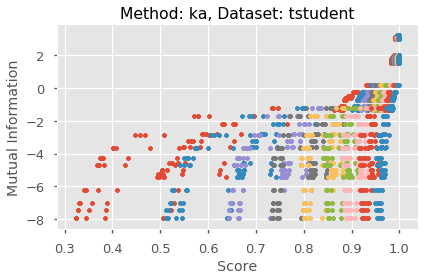

In [57]:
scorer = 'ka'
dataset = 'gauss'
fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'ka'
dataset = 'tstudent'
fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

In [58]:
#### Reasonable

In [59]:
demo_params = [
    ('median', 0.30000000000000004, None),
    ('median', 0.5, None),
    ('median', 0.7000000000000001, None),
]

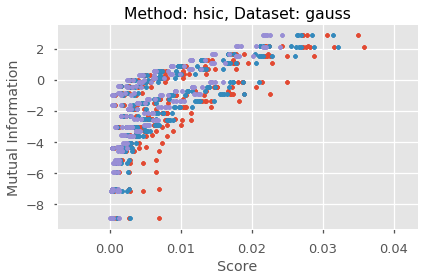

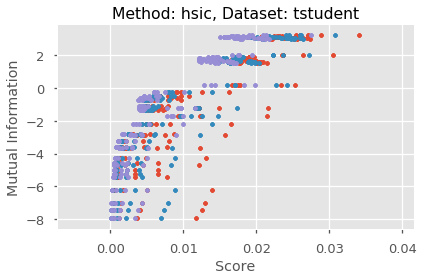

In [60]:
scorer = 'hsic'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'hsic'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

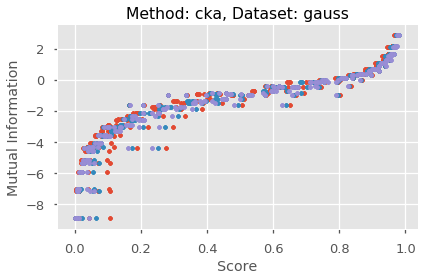

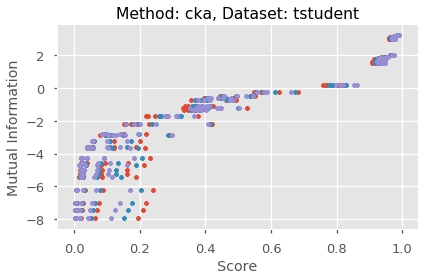

In [61]:
scorer = 'cka'
dataset = 'gauss'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'cka'
dataset = 'tstudent'

fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

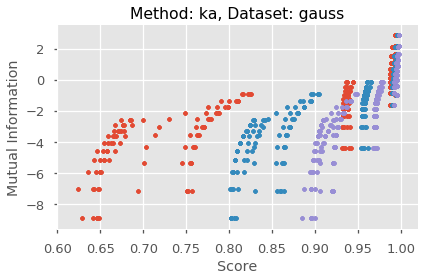

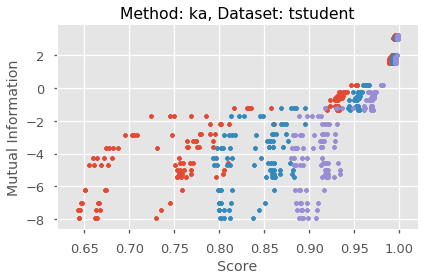

In [62]:
scorer = 'ka'
dataset = 'gauss'
fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")

scorer = 'ka'
dataset = 'tstudent'
fig, ax = plot_individual_scores(results_df, demo_params, scorer, dataset, mi_scale=np.log2)
ax.set_xlabel(f"Score")
ax.set_ylabel(f"Mutual Information")
ax.set_title(f"Method: {scorer}, Dataset: {dataset}")
# ax.legend()
plt.tight_layout()
fig.savefig(f"{FIG_PATH}{scorer}_{dataset}_median_all.png")